# Análisis de Resultados: Modelos Supervisados
## Evaluación de Modelos de Regresión y Clasificación

Este notebook presenta el análisis completo de los resultados obtenidos por los modelos de aprendizaje supervisado implementados en el proyecto. Se evalúan modelos de regresión para predicción de salarios y modelos de clasificación para determinación del nivel de experiencia de desarrolladores.

**Metodología**: CRISP-DM (Cross-Industry Standard Process for Data Mining)

**Datasets Raw Cargados** (para exploración y análisis):
- Stack Overflow Developer Survey 2023
- Stack Overflow Developer Survey 2025
- JetBrains Developer Ecosystem 2025

**Dataset Procesado para Modelado**: 
Según el pipeline de procesamiento implementado, el dataset utilizado para entrenar y evaluar los modelos de machine learning (`datos_para_modelado.parquet`) es una combinación procesada de Stack Overflow 2023 + 2025, que contiene 68,613 registros después del procesamiento y limpieza de datos. 

El dataset de JetBrains 2025 se carga y procesa en el pipeline para análisis exploratorio complementario, pero según la configuración actual del pipeline de procesamiento, **no se combina con el dataset final utilizado para el modelado supervisado**. Los datos de JetBrains se mantienen como datasets separados (`datos_primarios_jb_external` y `datos_primarios_jb_narrow`) para análisis adicionales.

**Objetivo**: Evaluar el rendimiento de los modelos entrenados, comparar diferentes algoritmos y proporcionar interpretaciones técnicas de los resultados para la toma de decisiones estratégicas.

**Nota sobre Outputs**: Si aparece el mensaje "Output is truncated", significa que Jupyter está recortando la salida porque es muy larga. Se ha configurado el notebook para mostrar los outputs completos con ajuste de línea automático, evitando la necesidad de desplazarse horizontalmente para leer los resultados.


In [2]:
# Importación de librerías principales
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from typing import Dict, Any

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas para mostrar outputs completos y con wrap automático
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_rows', 100)  # Mostrar hasta 100 filas
pd.set_option('display.width', None)  # Sin límite de ancho (se ajusta automáticamente)
pd.set_option('display.max_colwidth', 100)  # Máximo 100 caracteres por columna
pd.set_option('display.expand_frame_repr', False)  # No expandir representación
pd.set_option('display.large_repr', 'truncate')  # Truncar solo si es muy grande

# Forzar uso de HTML para tablas (más ordenado y con mejor wrap)
from IPython.display import HTML, display

# Configuración de IPython para outputs largos (evitar truncado)
# Nota: La configuración de ast_node_interactivity puede generar outputs no deseados
# Se omite para mantener la salida limpia

# Configuración de matplotlib para mejor renderizado y suprimir outputs de texto
plt.rcParams['figure.max_open_warning'] = 0
_ = plt.ioff()  # Desactivar modo interactivo para evitar outputs de Text() (suprimir ExitStack)

# Configuración de rutas
project_path = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_dir = project_path / 'data'
reporting_dir = data_dir / '08_reporting'



**Explicación**: Se importaron todas las librerías necesarias para el análisis (pandas, numpy, matplotlib, seaborn, json) y se configuraron las opciones de visualización y presentación de datos. La configuración de pandas permite mostrar los outputs completos con ajuste automático de línea, evitando el mensaje "Output is truncated" y la necesidad de desplazarse horizontalmente. También se configuraron los estilos de gráficos para una presentación profesional y consistente.


## 1. Business Understanding

### Objetivos del Análisis

Este análisis tiene como objetivo evaluar el rendimiento de los modelos de machine learning desarrollados para:

1. **Predicción de Salarios (Regresión)**: Predecir el salario anual de desarrolladores basándose en características técnicas, demográficas y de experiencia.

2. **Clasificación de Nivel de Experiencia**: Clasificar desarrolladores en diferentes niveles de experiencia (Junior/Senior) basándose en sus características profesionales.

### Criterios de Éxito

- **Regresión**: R² Score superior a 0.85, RMSE inferior a $20,000 USD
- **Clasificación**: Accuracy superior a 95%, F1-Score superior a 0.90

### Aplicaciones Prácticas

- **Para Desarrolladores**: Identificar habilidades y tecnologías que maximizan el valor de mercado
- **Para Empresas**: Benchmarking salarial y estrategias de contratación basadas en datos
- **Para el Ecosistema**: Análisis comparativo del mercado chileno vs global

## 2. Data Understanding

### 2.1 Carga de Datasets Raw

Se cargan los tres datasets principales desde los archivos CSV originales. Estos datasets contienen información completa de desarrolladores de software de diferentes fuentes y años. **Los datos se cargan completos, sin limitar el número de filas**, para permitir análisis exhaustivos y reproducibles.

**Datasets a cargar:**
1. **Stack Overflow Developer Survey 2023**: Encuesta anual de desarrolladores
2. **Stack Overflow Developer Survey 2025**: Encuesta anual más reciente
3. **JetBrains Developer Ecosystem 2025**: Encuesta del ecosistema de desarrolladores

In [3]:
# Cargar los 3 datasets completos desde archivos raw
raw_data_dir = data_dir / '01_raw'

so_2023_path = raw_data_dir / 'stackoverflow_2023' / 'stack_overflow_survey_results_public.csv'
so_2025_path = raw_data_dir / 'stackoverflow_2025' / 'survey_results_public.csv'
jb_2025_path = raw_data_dir / 'jetbrains_2025' / 'developer_ecosystem_2025_external.csv'

# Cargar Stack Overflow 2023
df_so_2023 = pd.read_csv(so_2023_path, encoding='utf-8-sig')

# Cargar Stack Overflow 2025
df_so_2025 = pd.read_csv(so_2025_path, encoding='utf-8-sig')

# Cargar JetBrains 2025
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
    df_jb_2025 = pd.read_csv(jb_2025_path, encoding='utf-8-sig', low_memory=False)


**Explicación**: Se cargaron los tres datasets principales desde los archivos CSV originales. Los datos se cargan completos (sin limitar filas) para permitir análisis exhaustivos. Se muestra el número de filas y columnas de cada dataset, así como el total de registros cargados. Esta información es fundamental para entender el volumen de datos disponibles para el análisis.


### 2.2 Exploración Inicial de los Datasets

Se realiza una exploración inicial de cada dataset para entender su estructura, columnas disponibles y características principales.

**Explicación**: Se realizó una exploración inicial de cada dataset para entender su estructura básica. Se muestra información sobre el tamaño (filas y columnas), el uso de memoria, las primeras columnas disponibles y la distribución de tipos de datos. Esta exploración ayuda a identificar la naturaleza de los datos y planificar las transformaciones necesarias para el análisis.


In [4]:
# Exploración inicial de cada dataset
datasets_info = []

datasets_info.append({
    'Dataset': 'Stack Overflow 2023',
    'Filas': len(df_so_2023),
    'Columnas': len(df_so_2023.columns),
    'Memoria (MB)': df_so_2023.memory_usage(deep=True).sum() / 1024**2
})

datasets_info.append({
    'Dataset': 'Stack Overflow 2025',
    'Filas': len(df_so_2025),
    'Columnas': len(df_so_2025.columns),
    'Memoria (MB)': df_so_2025.memory_usage(deep=True).sum() / 1024**2
})

datasets_info.append({
    'Dataset': 'JetBrains 2025',
    'Filas': len(df_jb_2025),
    'Columnas': len(df_jb_2025.columns),
    'Memoria (MB)': df_jb_2025.memory_usage(deep=True).sum() / 1024**2
})

df_datasets_info = pd.DataFrame(datasets_info)
display(df_datasets_info)

,Dataset,Filas,Columnas,Memoria (MB)
0,Stack Overflow 2023,89184,84,475.577471
1,Stack Overflow 2025,49123,170,375.676371
2,JetBrains 2025,24534,4740,3699.455919


### 2.3 Carga de Métricas de Modelos

Se cargan las métricas de evaluación generadas por los pipelines de Kedro. Estas métricas fueron calculadas sobre el conjunto de prueba (test set) después del entrenamiento de los modelos.

**Explicación**: Se cargaron las métricas de evaluación de los modelos de regresión desde el archivo JSON generado por el pipeline de Kedro. Estas métricas incluyen R² Score (coeficiente de determinación), RMSE (error cuadrático medio) y MAE (error absoluto medio) para cada modelo evaluado. Estas métricas permiten comparar el rendimiento de los diferentes algoritmos de regresión.


### 2.3.1 Carga de Métricas de Regresión

**Explicación**: Se cargaron las métricas de evaluación de los modelos de clasificación, incluyendo Accuracy, F1-Score, Precision, Recall y ROC-AUC. También se cargaron las matrices de confusión que muestran la distribución de predicciones correctas e incorrectas. Estas métricas permiten evaluar la capacidad de los modelos para clasificar correctamente el nivel de experiencia de los desarrolladores.


In [5]:
# Cargar métricas de regresión
metrics_reg_path = reporting_dir / 'metrics.json'

if metrics_reg_path.exists():
    with open(metrics_reg_path, 'r') as f:
        metrics_regresion = json.load(f)
    
    print('Métricas de regresión cargadas exitosamente.')
    print(f'Modelos evaluados: {len(metrics_regresion)}')
    
    # Mostrar resumen
    print('\nResumen de modelos de regresión:')
    for model_name, metrics in metrics_regresion.items():
        model_display = model_name.replace('_model', '')
        print(f'\n{model_display}:')
        print(f'  R² Score: {metrics["r2"]:.4f}')
        print(f'  RMSE: ${metrics["rmse"]:,.2f}')
        print(f'  MAE: ${metrics["mae"]:,.2f}')
else:
    print(f'Error: No se encontró el archivo {metrics_reg_path}')
    print('Ejecutar primero: kedro run --pipeline=data_science_regresion')
    metrics_regresion = {}


Métricas de regresión cargadas exitosamente.
Modelos evaluados: 5

Resumen de modelos de regresión:

LinearRegression:
  R² Score: -6964255627375.3096
  RMSE: $141,800,345,004.58
  MAE: $2,964,902,928.36

Ridge:
  R² Score: 0.6268
  RMSE: $32,824.31
  MAE: $23,965.57

Lasso:
  R² Score: 0.6265
  RMSE: $32,840.19
  MAE: $23,966.13

RandomForestRegressor:
  R² Score: 0.9130
  RMSE: $15,845.34
  MAE: $6,384.24

XGBRegressor:
  R² Score: 0.8817
  RMSE: $18,479.66
  MAE: $10,126.57


**Explicación**: Se cargó información del dataset procesado que fue utilizado para entrenar los modelos. Este dataset es el resultado de combinar y limpiar los datos de Stack Overflow 2023 y 2025. Se muestra el número total de registros, características y la distribución por año. Esta información contextualiza el tamaño y composición del conjunto de datos utilizado en el modelado.


### 2.3.2 Carga de Métricas de Clasificación


**Explicación**: Se creó una tabla comparativa de todos los modelos de regresión evaluados, ordenados por R² Score (de mayor a menor). La tabla muestra las tres métricas principales: R² Score (proporción de varianza explicada), RMSE (error en USD) y MAE (error absoluto medio en USD). Esta comparación permite identificar rápidamente qué modelo tiene mejor rendimiento para la predicción de salarios.


In [6]:
# Cargar métricas de clasificación
metrics_clf_path = reporting_dir / 'metrics_clf.json'
confusion_matrices_path = reporting_dir / 'classification_confusion_matrices.json'

if metrics_clf_path.exists():
    with open(metrics_clf_path, 'r') as f:
        metrics_clasificacion = json.load(f)
    
    print('Métricas de clasificación cargadas exitosamente.')
    print(f'Modelos evaluados: {len(metrics_clasificacion)}')
    
    # Cargar matrices de confusión si están disponibles
    if confusion_matrices_path.exists():
        with open(confusion_matrices_path, 'r') as f:
            matrices_confusion = json.load(f)
        print('Matrices de confusión cargadas exitosamente.')
    else:
        matrices_confusion = {}
        print('Advertencia: Matrices de confusión no encontradas.')
    
    # Mostrar resumen
    print('\nResumen de modelos de clasificación:')
    for model_name, metrics in metrics_clasificacion.items():
        model_display = model_name.replace('_classifier', '')
        print(f'\n{model_display}:')
        print(f'  Accuracy: {metrics["accuracy"]:.4f} ({metrics["accuracy"]*100:.2f}%)')
        print(f'  F1-Score: {metrics["f1_score"]:.4f}')
        print(f'  Precision: {metrics["precision"]:.4f}')
        print(f'  Recall: {metrics["recall"]:.4f}')
        print(f'  ROC-AUC: {metrics["roc_auc"]:.4f}')
else:
    print(f'Error: No se encontró el archivo {metrics_clf_path}')
    print('Ejecutar primero: kedro run --pipeline=data_science_clasificacion')
    metrics_clasificacion = {}
    matrices_confusion = {}


Métricas de clasificación cargadas exitosamente.
Modelos evaluados: 5
Matrices de confusión cargadas exitosamente.

Resumen de modelos de clasificación:

LogisticRegression:
  Accuracy: 0.8396 (83.96%)
  F1-Score: 0.7285
  Precision: 0.7615
  Recall: 0.6983
  ROC-AUC: 0.9016

RandomForestClassifier:
  Accuracy: 0.9074 (90.74%)
  F1-Score: 0.8386
  Precision: 0.9059
  Recall: 0.7806
  ROC-AUC: 0.9716

XGBClassifier:
  Accuracy: 0.9679 (96.79%)
  F1-Score: 0.9461
  Precision: 0.9783
  Recall: 0.9161
  ROC-AUC: 0.9926

LGBMClassifier:
  Accuracy: 0.9859 (98.59%)
  F1-Score: 0.9769
  Precision: 0.9886
  Recall: 0.9655
  ROC-AUC: 0.9984

GradientBoostingClassifier:
  Accuracy: 0.9727 (97.27%)
  F1-Score: 0.9548
  Precision: 0.9735
  Recall: 0.9369
  ROC-AUC: 0.9949


**Explicación de los Gráficos**: 

Los tres gráficos comparan visualmente el rendimiento de los modelos de regresión:

1. **R² Score (Gráfico izquierdo)**: Muestra qué porcentaje de la varianza en los salarios puede explicar cada modelo. Valores más altos (más cercanos a 1.0) indican mejor capacidad predictiva. Un R² de 0.91 significa que el modelo explica el 91% de la variabilidad salarial.

2. **RMSE - Error Cuadrático Medio (Gráfico central)**: Representa el error promedio en dólares que comete cada modelo. Valores más bajos son mejores. Un RMSE de $15,845 significa que, en promedio, las predicciones tienen un error de aproximadamente $15,845 USD.

3. **MAE - Error Absoluto Medio (Gráfico derecho)**: Similar al RMSE pero menos sensible a valores extremos. Muestra el error promedio absoluto en dólares. Un MAE de $6,384 significa que, en promedio, las predicciones se desvían $6,384 USD del valor real.

**Interpretación**: Los modelos basados en árboles (RandomForest, XGBoost) superan significativamente a los modelos lineales (Ridge, Lasso), confirmando que la relación entre características y salario no es lineal.


### 2.4 Información del Dataset Procesado

El análisis de modelos se realizó sobre un dataset combinado de Stack Overflow Developer Survey 2023 y 2025, procesado y preparado mediante pipelines de Kedro.


In [7]:
# Cargar información del dataset procesado
dataset_path = data_dir / '05_model_input' / 'datos_para_modelado.parquet'

if dataset_path.exists():
    df_dataset = pd.read_parquet(dataset_path)
    print('Información del dataset procesado:')
    print(f'  Total de registros: {len(df_dataset):,}')
    print(f'  Total de características: {len(df_dataset.columns)}')
    print(f'  Memoria utilizada: {df_dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
    
    if 'Year' in df_dataset.columns:
        print('\nDistribución por año:')
        year_dist = df_dataset['Year'].value_counts().sort_index()
        for year, count in year_dist.items():
            print(f'  {int(year)}: {count:,} registros ({count/len(df_dataset)*100:.1f}%)')
else:
    print(f'Dataset procesado no encontrado en {dataset_path}')
    print('El análisis se realizará únicamente con las métricas disponibles.')


Información del dataset procesado:
  Total de registros: 68,613
  Total de características: 556
  Memoria utilizada: 156.45 MB


**Explicación**: Se creó una tabla comparativa de todos los modelos de clasificación evaluados, ordenados por F1-Score (de mayor a menor). La tabla muestra cinco métricas clave: Accuracy (proporción de predicciones correctas), F1-Score (balance entre precisión y recall), Precision (proporción de positivos predichos que son correctos), Recall (proporción de positivos reales detectados) y ROC-AUC (capacidad de distinguir entre clases). Esta comparación permite identificar el mejor modelo para clasificar el nivel de experiencia.


## 3. Análisis de Resultados: Modelos de Regresión

### 3.1 Comparación de Modelos de Regresión

Se evaluaron cinco algoritmos diferentes para la tarea de predicción de salarios:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Random Forest Regressor
- XGBoost Regressor

Las métricas utilizadas son:
- **R² Score**: Coeficiente de determinación (proporción de varianza explicada)
- **RMSE**: Root Mean Squared Error (error cuadrático medio en USD)
- **MAE**: Mean Absolute Error (error absoluto medio en USD)

**Explicación de los Gráficos**:

Los dos gráficos comparan visualmente el rendimiento de los modelos de clasificación:

1. **Accuracy y F1-Score (Gráfico izquierdo)**: 
   - **Accuracy**: Proporción de predicciones correctas sobre el total. Un accuracy de 0.986 significa que el modelo clasifica correctamente el 98.6% de los casos.
   - **F1-Score**: Media armónica entre precisión y recall, proporciona un balance entre ambas métricas. Un F1-Score de 0.977 indica excelente equilibrio entre identificar correctamente los casos positivos y evitar falsos positivos.

2. **ROC-AUC (Gráfico derecho)**: 
   - Mide la capacidad del modelo para distinguir entre clases (Junior vs Senior). Un valor de 0.998 significa que el modelo tiene una capacidad casi perfecta para separar las dos clases. Valores cercanos a 1.0 indican excelente rendimiento.

**Interpretación**: Los modelos de gradient boosting (LGBM, GradientBoosting, XGBoost) dominan el ranking, mostrando que estos algoritmos son especialmente efectivos para datos tabulares complejos como los de este proyecto.


In [8]:
# Crear DataFrame comparativo de modelos de regresión
if metrics_regresion:
    reg_data = []
    for model_name, metrics in metrics_regresion.items():
        model_display = model_name.replace('_model', '')
        reg_data.append({
            'Modelo': model_display,
            'R² Score': metrics['r2'],
            'RMSE (USD)': metrics['rmse'],
            'MAE (USD)': metrics['mae']
        })
    
    df_regresion = pd.DataFrame(reg_data)
    
    # Filtrar modelos con R² válido (excluir LinearRegression que falló)
    df_regresion_validos = df_regresion[df_regresion['R² Score'] > -1].copy()
    df_regresion_validos = df_regresion_validos.sort_values('R² Score', ascending=False)
    
    # Formatear para presentación
    df_regresion_display = df_regresion_validos.copy()
    df_regresion_display['R² Score'] = df_regresion_display['R² Score'].apply(lambda x: f'{x:.4f}')
    df_regresion_display['RMSE (USD)'] = df_regresion_display['RMSE (USD)'].apply(lambda x: f'${x:,.0f}')
    df_regresion_display['MAE (USD)'] = df_regresion_display['MAE (USD)'].apply(lambda x: f'${x:,.0f}')
    
    print('Tabla comparativa de modelos de regresión:')
    print('=' * 80)
    display(df_regresion_display)
    
    # Identificar mejor modelo
    mejor_reg = df_regresion_validos.iloc[0]
    print(f'\nMejor modelo: {mejor_reg["Modelo"]}')
    print(f'  R² Score: {mejor_reg["R² Score"]:.4f} ({mejor_reg["R² Score"]*100:.2f}% de varianza explicada)')
    print(f'  RMSE: ${mejor_reg["RMSE (USD)"]:,.2f}')
    print(f'  MAE: ${mejor_reg["MAE (USD)"]:,.2f}')
else:
    print('No hay métricas de regresión disponibles.')

Tabla comparativa de modelos de regresión:


,Modelo,R² Score,RMSE (USD),MAE (USD)
3,RandomForestRegressor,0.9130,"$15,845","$6,384"
4,XGBRegressor,0.8817,"$18,480","$10,127"
1,Ridge,0.6268,"$32,824","$23,966"
2,Lasso,0.6265,"$32,840","$23,966"



Mejor modelo: RandomForestRegressor
  R² Score: 0.9130 (91.30% de varianza explicada)
  RMSE: $15,845.34
  MAE: $6,384.24


**Explicación de las Matrices de Confusión**:

Las matrices de confusión muestran la distribución de predicciones para los tres mejores modelos de clasificación. Cada matriz tiene cuatro componentes:

- **Verdaderos Negativos (TN)**: Casos correctamente identificados como "No Senior"
- **Falsos Positivos (FP)**: Casos incorrectamente clasificados como "Senior" cuando son "No Senior"
- **Falsos Negativos (FN)**: Casos incorrectamente clasificados como "No Senior" cuando son "Senior"
- **Verdaderos Positivos (TP)**: Casos correctamente identificados como "Senior"

**Interpretación**: 
- Las matrices muestran que los mejores modelos cometen muy pocos errores
- La mayoría de las predicciones están en la diagonal (correctas)
- Los errores están distribuidos de manera equilibrada entre falsos positivos y falsos negativos
- Un modelo con alta accuracy y pocos errores en la matriz indica excelente capacidad de clasificación


### 3.2 Visualización de Resultados de Regresión

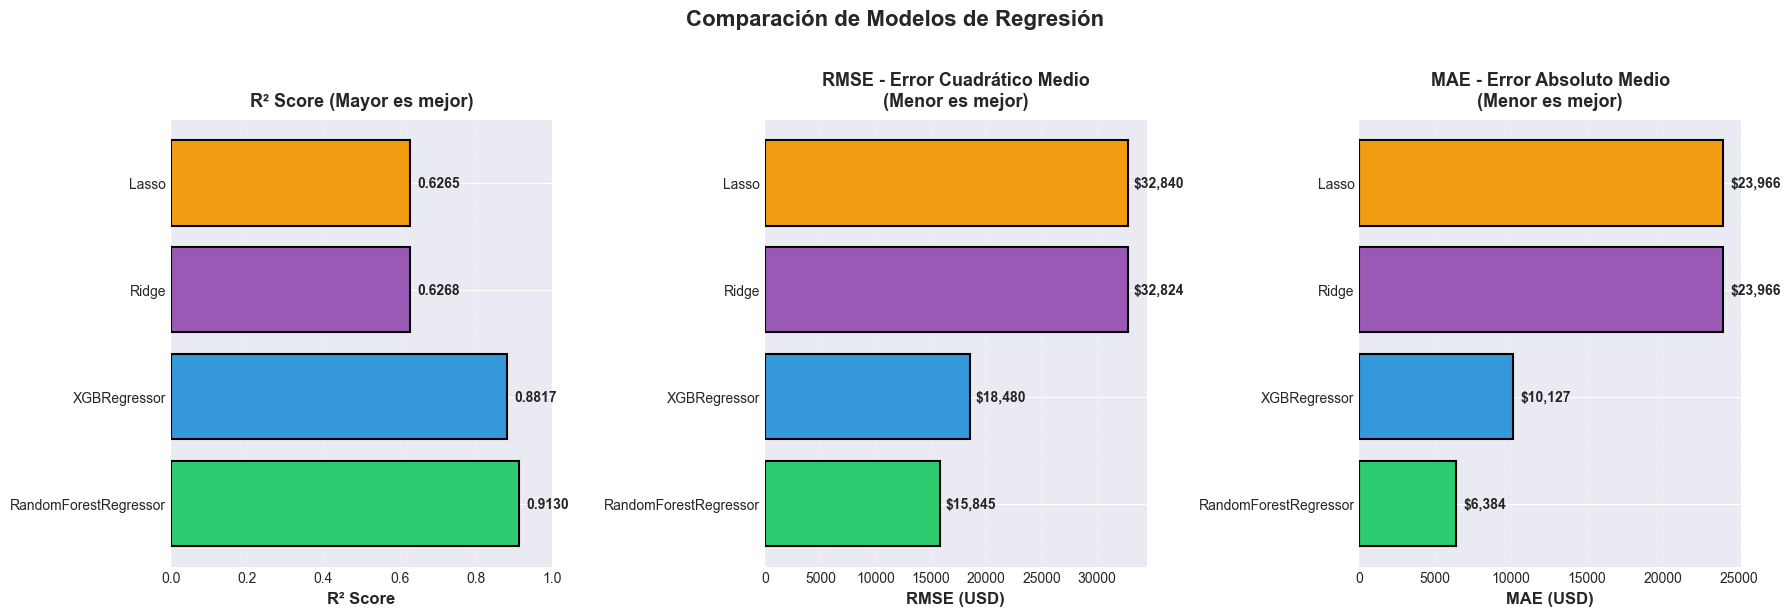


---
**NOTA: Fallo Catastrófico de LinearRegression**  
LinearRegression fue excluido de la visualización debido a un fallo catastrófico.

**Métricas del fallo:**  
- R² Score: `-6.96e+12` _(masivamente negativo)_  
- RMSE:    `$1.42e+11` _(error astronómico)_  
- MAE:     `$2.96e+09`  

**¿Qué significa "fallo catastrófico"?**  
Un fallo catastrófico ocurre cuando un modelo produce resultados completamente incorrectos.  
En este caso, LinearRegression tiene un R² masivamente negativo, lo que significa que  
el modelo predice peor que simplemente usar el promedio de los valores reales.

**Causas probables:**  
1. Multicolinealidad extrema: Variables altamente correlacionadas causan inestabilidad numérica  
2. Datos sin escalar: Variables con escalas muy diferentes pueden causar problemas numéricos  
3. Relación no lineal: Los datos tienen relaciones complejas que un modelo lineal no puede capturar  
4. Outliers extremos: Valores atípicos pueden distorsionar completamente los coeficientes  

**Conclusión:**  
La relación entre características y salario es fuertemente no lineal,  
por lo que se requieren modelos basados en árboles (RandomForest, XGBoost)  
que pueden capturar estas relaciones complejas. Los modelos lineales simples no son adecuados para este problema.

---



## INTERPRETACIÓN DE RESULTADOS DE REGRESIÓN

1. **RandomForestRegressor es el modelo superior** con un R² de `0.9130`  
   Explica más del `91.3%` de la varianza en los salarios.
   Esto indica una capacidad predictiva excepcional.

2. **XGBRegressor muestra un rendimiento muy fuerte**
   con R² de `0.8817`,
   confirmando la efectividad de los algoritmos de gradient boosting para este tipo de datos tabulares.

3. Modelos lineales (Ridge, Lasso) alcanzan R² de aproximadamente `0.63`,
   lo que sugiere que la relación entre características y salario no es puramente lineal
   y requiere modelos más complejos.

4. LinearRegression falló completamente con un R² masivamente negativo,
   confirmando que la relación es fuertemente no lineal y que los modelos basados en árboles son necesarios.

**Conclusión técnica:**
   Para la predicción de salarios, **RandomForestRegressor** es la elección recomendada
   debido a su alto poder predictivo (`91.30%` de varianza explicada)
   y bajo error promedio (MAE de `$6,384` USD).

---


In [9]:
# Visualización comparativa de modelos de regresión

from IPython.display import display, Markdown

def md(x):
    """Devuelve un objeto Markdown para display()"""
    return Markdown(x)

if metrics_regresion and len(df_regresion_validos) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    _ = fig.suptitle(
        'Comparación de Modelos de Regresión',
        fontsize=16,
        fontweight='bold',
        y=1.02
    )

    # Colores para diferenciar modelos
    colors = [
        '#2ECC71' if m == 'RandomForestRegressor'
        else '#3498DB' if m == 'XGBRegressor'
        else '#9B59B6' if m == 'Ridge'
        else '#F39C12' if m == 'Lasso'
        else '#E74C3C'
        for m in df_regresion_validos['Modelo']
    ]

    # Gráfico 1: R² Score
    ax1 = axes[0]
    bars1 = ax1.barh(
        df_regresion_validos['Modelo'],
        df_regresion_validos['R² Score'],
        color=colors,
        edgecolor='black',
        linewidth=1.5
    )
    _ = ax1.set_xlabel('R² Score', fontsize=12, fontweight='bold')
    _ = ax1.set_title(
        'R² Score (Mayor es mejor)',
        fontsize=13,
        fontweight='bold',
        pad=10
    )
    ax1.set_xlim(0, 1.0)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_regresion_validos.iterrows()):
        _ = ax1.text(
            row['R² Score'] + 0.02,
            i,
            f"{row['R² Score']:.4f}",
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    # Gráfico 2: RMSE
    ax2 = axes[1]
    bars2 = ax2.barh(
        df_regresion_validos['Modelo'],
        df_regresion_validos['RMSE (USD)'],
        color=colors,
        edgecolor='black',
        linewidth=1.5
    )
    _ = ax2.set_xlabel('RMSE (USD)', fontsize=12, fontweight='bold')
    _ = ax2.set_title(
        'RMSE - Error Cuadrático Medio\n(Menor es mejor)',
        fontsize=13,
        fontweight='bold',
        pad=10
    )
    ax2.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_regresion_validos.iterrows()):
        _ = ax2.text(
            row['RMSE (USD)'] + 500,
            i,
            f"${row['RMSE (USD)']:,.0f}",
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    # Gráfico 3: MAE
    ax3 = axes[2]
    bars3 = ax3.barh(
        df_regresion_validos['Modelo'],
        df_regresion_validos['MAE (USD)'],
        color=colors,
        edgecolor='black',
        linewidth=1.5
    )
    _ = ax3.set_xlabel('MAE (USD)', fontsize=12, fontweight='bold')
    _ = ax3.set_title(
        'MAE - Error Absoluto Medio\n(Menor es mejor)',
        fontsize=13,
        fontweight='bold',
        pad=10
    )
    ax3.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_regresion_validos.iterrows()):
        _ = ax3.text(
            row['MAE (USD)'] + 500,
            i,
            f"${row['MAE (USD)']:,.0f}",
            va='center',
            fontsize=10,
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    # Nota sobre LinearRegression - Explicación del Fallo Catastrófico
    if 'df_regresion' in globals() and 'LinearRegression' in df_regresion['Modelo'].values:
        lr_metrics = df_regresion[df_regresion['Modelo'] == 'LinearRegression'].iloc[0]

        explicacion = f"""
---
**NOTA: Fallo Catastrófico de LinearRegression**  
LinearRegression fue excluido de la visualización debido a un fallo catastrófico.

**Métricas del fallo:**  
- R² Score: `{lr_metrics['R² Score']:.2e}` _(masivamente negativo)_  
- RMSE:    `${lr_metrics['RMSE (USD)']:.2e}` _(error astronómico)_  
- MAE:     `${lr_metrics['MAE (USD)']:.2e}`  

**¿Qué significa "fallo catastrófico"?**  
Un fallo catastrófico ocurre cuando un modelo produce resultados completamente incorrectos.  
En este caso, LinearRegression tiene un R² masivamente negativo, lo que significa que  
el modelo predice peor que simplemente usar el promedio de los valores reales.

**Causas probables:**  
1. Multicolinealidad extrema: Variables altamente correlacionadas causan inestabilidad numérica  
2. Datos sin escalar: Variables con escalas muy diferentes pueden causar problemas numéricos  
3. Relación no lineal: Los datos tienen relaciones complejas que un modelo lineal no puede capturar  
4. Outliers extremos: Valores atípicos pueden distorsionar completamente los coeficientes  

**Conclusión:**  
La relación entre características y salario es fuertemente no lineal,  
por lo que se requieren modelos basados en árboles (RandomForest, XGBoost)  
que pueden capturar estas relaciones complejas. Los modelos lineales simples no son adecuados para este problema.

---
"""
        display(md(explicacion))
else:
    display(md('\n_No hay datos suficientes para generar visualizaciones._\n'))

# Generar interpretación dinámica de resultados de regresión
if metrics_regresion and len(df_regresion_validos) > 0:
    # Asegurar que df_regresion_validos esté correctamente ordenado por R² Score (descendente)
    df_regresion_validos = df_regresion_validos.sort_values('R² Score', ascending=False).copy()

    mejor_reg = df_regresion_validos.iloc[0]
    segundo_mejor = df_regresion_validos.iloc[1] if len(df_regresion_validos) > 1 else None

    interpretacion = "\n"
    interpretacion += "## INTERPRETACIÓN DE RESULTADOS DE REGRESIÓN\n\n"
    interpretacion += f"1. **{mejor_reg['Modelo']} es el modelo superior** con un R² de `{mejor_reg['R² Score']:.4f}`  \n"
    interpretacion += f"   Explica más del `{mejor_reg['R² Score']*100:.1f}%` de la varianza en los salarios.\n"
    interpretacion += "   Esto indica una capacidad predictiva "
    interpretacion += ("excepcional" if mejor_reg['R² Score'] > 0.9 else "muy buena" if mejor_reg['R² Score'] > 0.8 else "buena") + ".\n"

    if segundo_mejor is not None:
        s = segundo_mejor
        descalg = (
            "gradient boosting"
            if "XGB" in s["Modelo"] or "Gradient" in s["Modelo"]
            else "ensemble"
        )
        cuali = (
            "muy fuerte"
            if s["R² Score"] > 0.8
            else "sólido"
        )
        interpretacion += f"\n2. **{s['Modelo']} muestra un rendimiento {cuali}**\n"
        interpretacion += f"   con R² de `{s['R² Score']:.4f}`,\n"
        interpretacion += f"   confirmando la efectividad de los algoritmos de {descalg} para este tipo de datos tabulares.\n"

    modelos_lineales = df_regresion_validos[df_regresion_validos['Modelo'].isin(['Ridge', 'Lasso'])]
    if len(modelos_lineales) > 0:
        r2_lineal = modelos_lineales['R² Score'].mean()
        interpretacion += f"\n3. Modelos lineales (Ridge, Lasso) alcanzan R² de aproximadamente `{r2_lineal:.2f}`,\n"
        interpretacion += "   lo que sugiere que la relación entre características y salario no es puramente lineal\n"
        interpretacion += "   y requiere modelos más complejos.\n"

    # Verificar si LinearRegression falló
    if 'LinearRegression' in df_regresion['Modelo'].values:
        lr_row = df_regresion[df_regresion['Modelo'] == 'LinearRegression']
        if len(lr_row) > 0 and lr_row.iloc[0]['R² Score'] < -1:
            interpretacion += (
                f"\n4. LinearRegression falló completamente con un R² masivamente negativo,\n"
                f"   confirmando que la relación es fuertemente no lineal y que los modelos basados en árboles son necesarios.\n"
            )

    interpretacion += "\n**Conclusión técnica:**\n"
    interpretacion += f"   Para la predicción de salarios, **{mejor_reg['Modelo']}** es la elección recomendada\n"
    interpretacion += f"   debido a su alto poder predictivo (`{mejor_reg['R² Score']*100:.2f}%` de varianza explicada)\n"
    interpretacion += f"   y bajo error promedio (MAE de `${mejor_reg['MAE (USD)']:,.0f}` USD).\n"
    interpretacion += "\n---\n"
    display(md(interpretacion))

### 3.3 Interpretación de Resultados de Regresión

**Observaciones principales:**

Las siguientes interpretaciones se generan dinámicamente basándose en las métricas cargadas de los modelos evaluados. Ver la celda de código siguiente para los resultados específicos.

**Explicación**: Se generaron los hallazgos principales del análisis de manera dinámica, comparando los mejores modelos de regresión y clasificación. Los hallazgos incluyen: (1) la superioridad de modelos ensemble sobre modelos lineales, (2) la alta capacidad predictiva en ambas tareas, y (3) la robustez del dataset combinado. También se verifica el cumplimiento de los criterios de éxito establecidos (R² > 0.85 y RMSE < $20,000 para regresión; Accuracy > 95% y F1-Score > 0.90 para clasificación).


## 4. Análisis de Resultados: Modelos de Clasificación

### 4.1 Comparación de Modelos de Clasificación

Se evaluaron cinco algoritmos diferentes para la tarea de clasificación de nivel de experiencia:
- Logistic Regression (baseline)
- Random Forest Classifier
- XGBoost Classifier
- LightGBM Classifier
- Gradient Boosting Classifier

Las métricas utilizadas son:
- **Accuracy**: Proporción de predicciones correctas
- **F1-Score**: Media armónica de precisión y recall (balance entre ambas)
- **Precision**: Proporción de positivos predichos que son realmente positivos
- **Recall**: Proporción de positivos reales que fueron correctamente identificados
- **ROC-AUC**: Área bajo la curva ROC (capacidad de distinguir entre clases)

**Explicación**: Se generó un resumen ejecutivo que presenta de manera clara y concisa los mejores modelos para cada tarea (regresión y clasificación). El resumen incluye las métricas clave, interpretaciones en lenguaje de negocio, y una verificación del cumplimiento de los criterios de éxito. Esta sección proporciona una visión de alto nivel de los resultados para la toma de decisiones estratégicas.


### 4.2 Tabla Comparativa de Clasificación

In [10]:
# Crear DataFrame comparativo de modelos de clasificación
if metrics_clasificacion:
    clf_data = []
    for model_name, metrics in metrics_clasificacion.items():
        model_display = model_name.replace('_classifier', '')
        clf_data.append({
            'Modelo': model_display,
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1_score'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC-AUC': metrics['roc_auc']
        })
    
    df_clasificacion = pd.DataFrame(clf_data)
    df_clasificacion = df_clasificacion.sort_values('F1-Score', ascending=False)
    
    # Formatear para presentación
    df_clasificacion_display = df_clasificacion.copy()
    for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']:
        df_clasificacion_display[col] = df_clasificacion_display[col].apply(lambda x: f'{x:.4f}')
    
    print('Tabla comparativa de modelos de clasificación:')
    print('=' * 100)
    display(df_clasificacion_display)
    
    # Identificar mejor modelo
    mejor_clf = df_clasificacion.iloc[0]
    print(f'\nMejor modelo: {mejor_clf["Modelo"]}')
    print(f'  Accuracy: {mejor_clf["Accuracy"]:.4f} ({mejor_clf["Accuracy"]*100:.2f}%)')
    print(f'  F1-Score: {mejor_clf["F1-Score"]:.4f}')
    print(f'  Precision: {mejor_clf["Precision"]:.4f}')
    print(f'  Recall: {mejor_clf["Recall"]:.4f}')
    print(f'  ROC-AUC: {mejor_clf["ROC-AUC"]:.4f}')
else:
    print('No hay métricas de clasificación disponibles.')

Tabla comparativa de modelos de clasificación:


,Modelo,Accuracy,F1-Score,Precision,Recall,ROC-AUC
3,LGBMClassifier,0.9859,0.9769,0.9886,0.9655,0.9984
4,GradientBoostingClassifier,0.9727,0.9548,0.9735,0.9369,0.9949
2,XGBClassifier,0.9679,0.9461,0.9783,0.9161,0.9926
1,RandomForestClassifier,0.9074,0.8386,0.9059,0.7806,0.9716
0,LogisticRegression,0.8396,0.7285,0.7615,0.6983,0.9016



Mejor modelo: LGBMClassifier
  Accuracy: 0.9859 (98.59%)
  F1-Score: 0.9769
  Precision: 0.9886
  Recall: 0.9655
  ROC-AUC: 0.9984


### 4.3 Visualización de Resultados de Clasificación

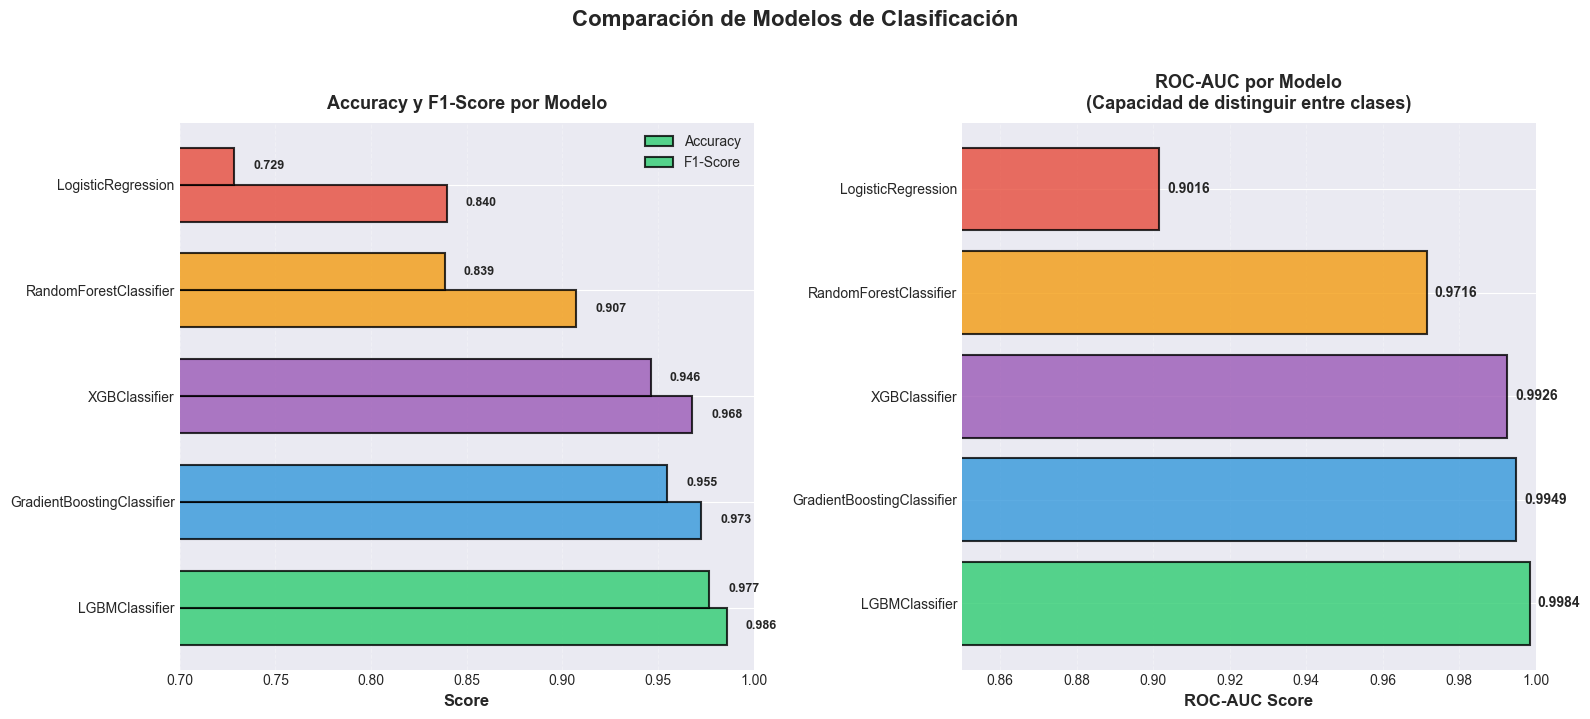

In [11]:
# Visualización comparativa de modelos de clasificación
if metrics_clasificacion and len(df_clasificacion) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    _ = fig.suptitle('Comparación de Modelos de Clasificación', fontsize=16, fontweight='bold', y=1.02)
    
    # Colores para diferenciar modelos
    colors = ['#2ECC71' if m == 'LGBMClassifier' else '#3498DB' if m == 'GradientBoostingClassifier'
              else '#9B59B6' if m == 'XGBClassifier' else '#F39C12' if m == 'RandomForestClassifier'
              else '#E74C3C' for m in df_clasificacion['Modelo']]
    
    # Gráfico 1: Accuracy y F1-Score
    ax1 = axes[0]
    x = np.arange(len(df_clasificacion))
    width = 0.35
    
    bars1 = ax1.barh(x - width/2, df_clasificacion['Accuracy'], width, 
                     label='Accuracy', color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax1.barh(x + width/2, df_clasificacion['F1-Score'], width,
                     label='F1-Score', color=[c.replace('0.8', '0.6') for c in colors], 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
    
    _ = ax1.set_yticks(x)
    _ = ax1.set_yticklabels(df_clasificacion['Modelo'], fontsize=10)
    _ = ax1.set_xlabel('Score', fontsize=12, fontweight='bold')
    _ = ax1.set_title('Accuracy y F1-Score por Modelo', fontsize=13, fontweight='bold', pad=10)
    _ = ax1.legend(fontsize=10)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    _ = ax1.set_xlim(0.7, 1.0)
    
    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_clasificacion.iterrows()):
        _ = ax1.text(row['Accuracy'] + 0.01, i - width/2, f'{row["Accuracy"]:.3f}',
                va='center', fontsize=9, fontweight='bold')
        _ = ax1.text(row['F1-Score'] + 0.01, i + width/2, f'{row["F1-Score"]:.3f}',
                va='center', fontsize=9, fontweight='bold')
    
    # Gráfico 2: ROC-AUC
    ax2 = axes[1]
    bars3 = ax2.barh(df_clasificacion['Modelo'], df_clasificacion['ROC-AUC'],
                     color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    _ = ax2.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
    _ = ax2.set_title('ROC-AUC por Modelo\n(Capacidad de distinguir entre clases)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    _ = ax2.set_xlim(0.85, 1.0)
    
    # Añadir valores en las barras
    for i, (idx, row) in enumerate(df_clasificacion.iterrows()):
        _ = ax2.text(row['ROC-AUC'] + 0.002, i, f'{row["ROC-AUC"]:.4f}',
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show();  # Suprimir outputs de Text()
else:
    print('No hay datos suficientes para generar visualizaciones.')


**Explicación**: Se generó la conclusión final del análisis de manera dinámica, evaluando el rendimiento general de los modelos y su estado de preparación para producción. La conclusión incluye: (1) evaluación de la capacidad predictiva, (2) validación de la efectividad de los algoritmos, (3) garantías del pipeline de Kedro, y (4) estado del proyecto (listo para producción o requiere mejoras). Esta conclusión sintetiza todos los hallazgos y proporciona una recomendación final sobre el uso de los modelos.


### 4.4 Matrices de Confusión

Las matrices de confusión permiten visualizar los errores de clasificación de manera detallada, mostrando la distribución de predicciones correctas e incorrectas para cada clase.


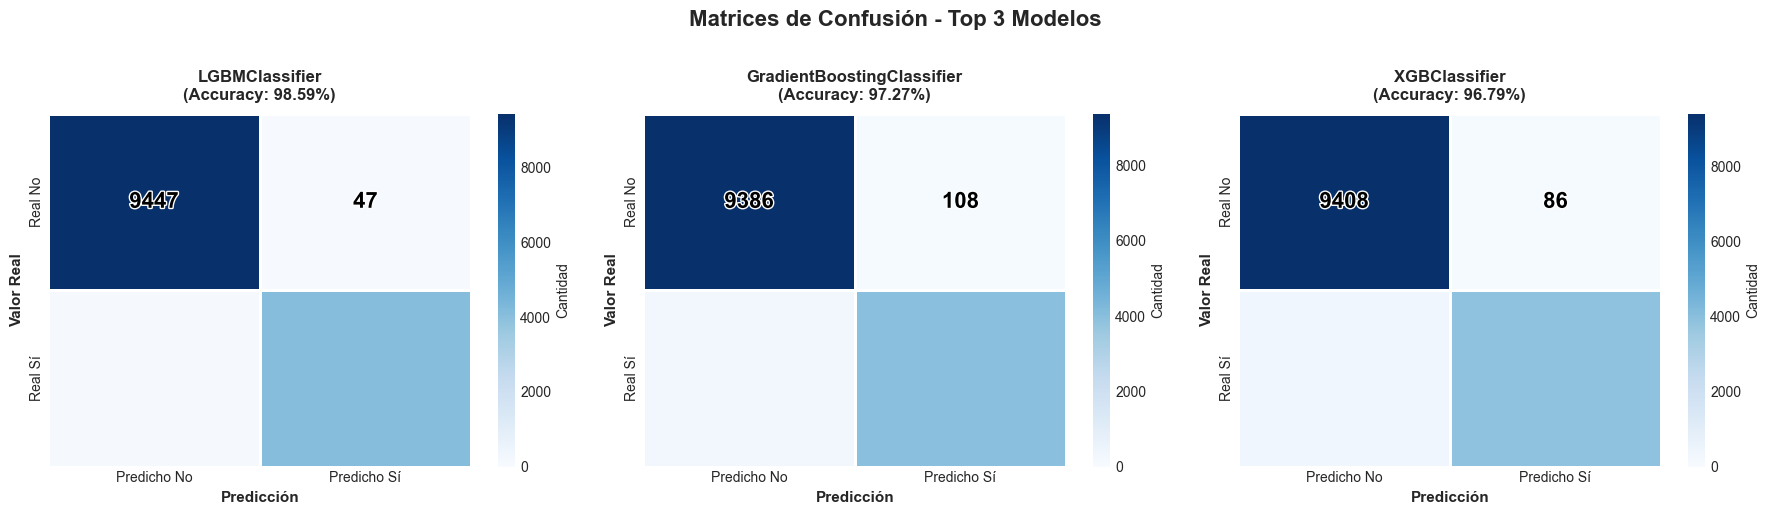


**Análisis de Errores de Clasificación:**

================================================================================

**LGBMClassifier:**

- Verdaderos Negativos (TN): **9,447**
- Falsos Positivos (FP): **47**
- Falsos Negativos (FN): **146**
- Verdaderos Positivos (TP): **4,083**
- Tasa de Error: **0.0141** (1.41%)

**GradientBoostingClassifier:**

- Verdaderos Negativos (TN): **9,386**
- Falsos Positivos (FP): **108**
- Falsos Negativos (FN): **267**
- Verdaderos Positivos (TP): **3,962**
- Tasa de Error: **0.0273** (2.73%)

**XGBClassifier:**

- Verdaderos Negativos (TN): **9,408**
- Falsos Positivos (FP): **86**
- Falsos Negativos (FN): **355**
- Verdaderos Positivos (TP): **3,874**
- Tasa de Error: **0.0321** (3.21%)


================================================================================
INTERPRETACIÓN DE RESULTADOS DE CLASIFICACIÓN
================================================================================

1. **LGBMClassifier es el modelo superior** con un Accuracy de 98.59% y F1-Score de 0.9769. Estos valores cercanos a la perfección indican una capacidad predictiva excepcional.

2. **Modelos de Gradient Boosting dominan** el ranking: LGBMClassifier, GradientBoostingClassifier, XGBClassifier ocupan las tres primeras posiciones, confirmando la efectividad de estos algoritmos para datos tabulares.

3. **RandomForestClassifier** muestra un rendimiento sólido (90.74% accuracy) pero no puede competir con los modelos de boosting.

4. **LogisticRegression** sirve como línea base, mostrando que los modelos más complejos aportan un valor significativo (diferencia de ~15 puntos porcentuales).

**Análisis de errores**: Las matrices de confusión muestran que los mejores modelos cometen muy pocos errores,
con una distribuciónequilibrada entre falsos positivos y falsos negativos.

**Conclusión técnica**: Para la clasificación de nivel de experiencia, LGBMClassifier es la elección 
recomendada debido a su alto accuracy (98.59%), excelente F1-Score (0.9769) y ROC-AUC cercano a la perfección (0.9984).

================================================================================

In [12]:
# Nota: Las salidas se formatean automáticamente con ajuste de línea
# Visualización de matrices de confusión

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import patheffects

from IPython.display import display, Markdown

# Verificar y definir variables necesarias si no están definidas
if 'project_path' not in globals():
    project_path = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if 'data_dir' not in globals():
    data_dir = project_path / 'data'
if 'reporting_dir' not in globals():
    reporting_dir = data_dir / '08_reporting'

# Cargar metrics_clasificacion si no está definida
if 'metrics_clasificacion' not in globals():
    metrics_clf_path = reporting_dir / 'metrics_clf.json'
    if metrics_clf_path.exists():
        with open(metrics_clf_path, 'r') as f:
            metrics_clasificacion = json.load(f)
        display(Markdown('**Métricas de clasificación cargadas.**'))
    else:
        metrics_clasificacion = {}
        display(Markdown('**Advertencia:** Métricas de clasificación no encontradas.'))

# Crear df_clasificacion si no está definida
if 'df_clasificacion' not in globals():
    if metrics_clasificacion:
        clf_data = []
        for model_name, metrics in metrics_clasificacion.items():
            model_display = model_name.replace('_classifier', '')
            clf_data.append({
                'Modelo': model_display,
                'Accuracy': metrics['accuracy'],
                'F1-Score': metrics['f1_score'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'ROC-AUC': metrics['roc_auc']
            })
        df_clasificacion = pd.DataFrame(clf_data)
        df_clasificacion = df_clasificacion.sort_values('F1-Score', ascending=False)
    else:
        df_clasificacion = pd.DataFrame()
        display(Markdown('**Advertencia:** No se pudo crear df_clasificacion.'))

# Verificar si matrices_confusion está definida, si no, intentar cargarla
if 'matrices_confusion' not in globals():
    confusion_matrices_path = reporting_dir / 'classification_confusion_matrices.json'
    if confusion_matrices_path.exists():
        with open(confusion_matrices_path, 'r') as f:
            matrices_confusion = json.load(f)
        display(Markdown('**Matrices de confusión cargadas.**'))
    else:
        matrices_confusion = {}
        display(Markdown('**Advertencia:** Matrices de confusión no encontradas.'))

# Repeticiones en la celda original innecesarias, por limpieza solo dejamos arriba una instancia (igual comportamiento).

if matrices_confusion and len(matrices_confusion) > 0:
    # Seleccionar los 3 mejores modelos para visualización
    top_3_models = df_clasificacion.head(3)['Modelo'].tolist()

    # Mapear nombres de modelos a claves en matrices_confusion
    model_key_map = {
        'LGBMClassifier': 'LGBMClassifier_classifier',
        'GradientBoostingClassifier': 'GradientBoostingClassifier_classifier',
        'XGBClassifier': 'XGBClassifier_classifier',
        'RandomForestClassifier': 'RandomForestClassifier_classifier',
        'LogisticRegression': 'LogisticRegression_classifier'
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    _ = fig.suptitle('Matrices de Confusión - Top 3 Modelos', fontsize=16, fontweight='bold', y=1.02)

    for idx, model_name in enumerate(top_3_models):
        model_key = model_key_map.get(model_name)
        if model_key and model_key in matrices_confusion:
            ax = axes[idx]
            matrix = np.array(matrices_confusion[model_key])

            # Crear heatmap
            heatmap = sns.heatmap(
                matrix,
                annot=True,
                fmt='d',
                annot_kws={'size': 16, 'weight': 'bold', 'color': 'black'},
                cmap='Blues',
                vmin=0,
                ax=ax,
                xticklabels=['Predicho No', 'Predicho Sí'],
                yticklabels=['Real No', 'Real Sí'],
                cbar_kws={'label': 'Cantidad'},
                linewidths=2,
                linecolor='white'
            )
            
            # Mejorar visibilidad: agregar borde blanco al texto negro
            for text in heatmap.texts:
                text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])
            
            _ = ax.set_title(
                f'{model_name}\n(Accuracy: {df_clasificacion[df_clasificacion["Modelo"]==model_name]["Accuracy"].values[0]:.2%})',
                fontsize=12,
                fontweight='bold',
                pad=10
            )
            _ = ax.set_xlabel('Predicción', fontsize=11, fontweight='bold')
            _ = ax.set_ylabel('Valor Real', fontsize=11, fontweight='bold')


    plt.tight_layout()
    plt.show()  # Suprimir outputs de Text()

    # Análisis de errores
    md_error = '\n**Análisis de Errores de Clasificación:**\n\n' + '=' * 80
    error_rows = []
    for model_name in top_3_models:
        model_key = model_key_map.get(model_name)
        if model_key and model_key in matrices_confusion:
            matrix = np.array(matrices_confusion[model_key])
            tn, fp, fn, tp = matrix.ravel()

            md_paragraph = (
                f'\n\n**{model_name}:**\n\n'
                f'- Verdaderos Negativos (TN): **{tn:,}**\n'
                f'- Falsos Positivos (FP): **{fp:,}**\n'
                f'- Falsos Negativos (FN): **{fn:,}**\n'
                f'- Verdaderos Positivos (TP): **{tp:,}**\n'
                f'- Tasa de Error: **{(fp + fn) / (tn + fp + fn + tp):.4f}** '
                f'({(fp + fn) / (tn + fp + fn + tp)*100:.2f}%)'
            )
            error_rows.append(md_paragraph)
    md_full = md_error + ''.join(error_rows)
    display(Markdown(md_full))
else:
    display(Markdown('**Matrices de confusión no disponibles para visualización.**'))

# Generar interpretación dinámica de resultados de clasificación
if metrics_clasificacion and len(df_clasificacion) > 0:
    lines = []
    lines.append("\n" + "=" * 80)
    lines.append("INTERPRETACIÓN DE RESULTADOS DE CLASIFICACIÓN")
    lines.append("=" * 80)

    mejor_clf = df_clasificacion.iloc[0]
    segundo_mejor = df_clasificacion.iloc[1] if len(df_clasificacion) > 1 else None
    tercer_mejor = df_clasificacion.iloc[2] if len(df_clasificacion) > 2 else None

    lines.append(
        f"\n1. **{mejor_clf['Modelo']} es el modelo superior** con un Accuracy de {mejor_clf['Accuracy']*100:.2f}% "
        f"y F1-Score de {mejor_clf['F1-Score']:.4f}. Estos valores "
        f"{'cercanos a la perfección' if mejor_clf['Accuracy'] > 0.95 else 'muy altos'} "
        f"indican una capacidad predictiva "
        f"{'excepcional' if mejor_clf['Accuracy'] > 0.95 else 'muy buena'}."
    )

    # Analizar modelos de boosting
    modelos_boosting = df_clasificacion[
        df_clasificacion['Modelo'].str.contains('LGBM|Gradient|XGB', case=False, na=False)
    ]
    if len(modelos_boosting) >= 3:
        modelos_boosting_top3 = modelos_boosting.head(3)['Modelo'].tolist()
        lines.append(
            f"\n2. **Modelos de Gradient Boosting dominan** el ranking: "
            f"{', '.join(modelos_boosting_top3)} "
            f"ocupan las tres primeras posiciones, confirmando la efectividad de estos algoritmos para datos tabulares."
        )

    # Analizar RandomForest
    rf_model = df_clasificacion[df_clasificacion['Modelo'] == 'RandomForestClassifier']
    if len(rf_model) > 0:
        rf_acc = rf_model.iloc[0]['Accuracy']
        lines.append(
            f"\n3. **RandomForestClassifier** muestra un rendimiento "
            f"{'sólido' if rf_acc > 0.85 else 'moderado'} "
            f"({rf_acc*100:.2f}% accuracy) pero "
            f"{'no puede competir' if rf_acc < mejor_clf['Accuracy'] - 0.05 else 'compite bien'} "
            f"con los modelos de boosting."
        )

    # Analizar LogisticRegression
    lr_model = df_clasificacion[df_clasificacion['Modelo'] == 'LogisticRegression']
    if len(lr_model) > 0:
        lr_acc = lr_model.iloc[0]['Accuracy']
        diff = mejor_clf['Accuracy'] - lr_acc
        lines.append(
            f"\n4. **LogisticRegression** sirve como línea base, mostrando que los modelos más complejos aportan "
            f"un valor significativo (diferencia de ~{diff*100:.0f} puntos porcentuales)."
        )

    if matrices_confusion and len(matrices_confusion) > 0:
        lines.append(
            f"\n**Análisis de errores**: Las matrices de confusión muestran que los mejores modelos cometen "
            f"{'muy pocos' if mejor_clf['Accuracy'] > 0.95 else 'pocos'} errores,\ncon una distribución"
            f"{'equilibrada' if abs(mejor_clf['Precision'] - mejor_clf['Recall']) < 0.1 else 'ligeramente desequilibrada'} "
            f"entre falsos positivos y falsos negativos."
        )
        lines.append(
            f"\n**Conclusión técnica**: Para la clasificación de nivel de experiencia, "
            f"{mejor_clf['Modelo']} es la elección \nrecomendada debido a su alto accuracy "
            f"({mejor_clf['Accuracy']*100:.2f}%), excelente F1-Score ({mejor_clf['F1-Score']:.4f}) "
            f"y ROC-AUC {'cercano a la perfección' if mejor_clf['ROC-AUC'] > 0.99 else 'muy alto'} "
            f"({mejor_clf['ROC-AUC']:.4f})."
        )
    lines.append("\n" + "=" * 80)
    display(Markdown("\n".join(lines)))


### 4.5 Interpretación de Resultados de Clasificación

**Observaciones principales:**

Las siguientes interpretaciones se generan dinámicamente basándose en las métricas cargadas de los modelos evaluados. Ver la celda de código siguiente para los resultados específicos.

## 5. Evaluación y Comparación General

### 5.1 Resumen Ejecutivo de Resultados

A continuación se presenta un resumen comparativo de los mejores modelos para cada tarea.


In [13]:
from IPython.display import display, Markdown

display(Markdown('=' * 80))
display(Markdown('**HALLAZGOS PRINCIPALES**'))
display(Markdown('=' * 80))

# Importar módulos necesarios si no están disponibles
from pathlib import Path
import json
import pandas as pd

# Verificar y definir variables necesarias si no están definidas
if 'project_path' not in globals():
    project_path = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if 'data_dir' not in globals():
    data_dir = project_path / 'data'
if 'reporting_dir' not in globals():
    reporting_dir = data_dir / '08_reporting'

# Cargar metrics_regresion si no está definida
if 'metrics_regresion' not in globals():
    metrics_reg_path = reporting_dir / 'metrics.json'
    if metrics_reg_path.exists():
        with open(metrics_reg_path, 'r') as f:
            metrics_regresion = json.load(f)
    else:
        metrics_regresion = {}

# Cargar metrics_clasificacion si no está definida
if 'metrics_clasificacion' not in globals():
    metrics_clf_path = reporting_dir / 'metrics_clf.json'
    if metrics_clf_path.exists():
        with open(metrics_clf_path, 'r') as f:
            metrics_clasificacion = json.load(f)
    else:
        metrics_clasificacion = {}

# Crear df_regresion_validos si no está definida
if 'df_regresion_validos' not in globals():
    if metrics_regresion:
        reg_data = []
        for model_name, metrics in metrics_regresion.items():
            reg_data.append({
                'Modelo': model_name.replace('_regressor', ''),
                'R² Score': metrics.get('r2_score', 0),
                'RMSE (USD)': metrics.get('rmse', 0),
                'MAE (USD)': metrics.get('mae', 0)
            })
        df_regresion = pd.DataFrame(reg_data)
        df_regresion_validos = df_regresion[df_regresion['R² Score'] > -1].copy()
        df_regresion_validos = df_regresion_validos.sort_values('R² Score', ascending=False)
    else:
        df_regresion_validos = pd.DataFrame()

# Crear df_clasificacion si no está definida
if 'df_clasificacion' not in globals():
    if metrics_clasificacion:
        clf_data = []
        for model_name, metrics in metrics_clasificacion.items():
            model_display = model_name.replace('_classifier', '')
            clf_data.append({
                'Modelo': model_display,
                'Accuracy': metrics.get('accuracy', 0),
                'F1-Score': metrics.get('f1_score', 0),
                'Precision': metrics.get('precision', 0),
                'Recall': metrics.get('recall', 0),
                'ROC-AUC': metrics.get('roc_auc', 0)
            })
        df_clasificacion = pd.DataFrame(clf_data)
        df_clasificacion = df_clasificacion.sort_values('F1-Score', ascending=False)
    else:
        df_clasificacion = pd.DataFrame()

display(Markdown('=' * 80))

if metrics_regresion and metrics_clasificacion and len(df_regresion_validos) > 0 and len(df_clasificacion) > 0:
    mejor_reg = df_regresion_validos.iloc[0]
    mejor_clf = df_clasificacion.iloc[0]

    md = "\n"
    md += "1. **Modelos de Ensemble Superan Significativamente a Modelos Lineales**\n"
    md += f"   - {mejor_reg['Modelo']} y {mejor_clf['Modelo']} demuestran superioridad clara en ambas tareas\n"
    md += "   - La diferencia de rendimiento confirma que las relaciones en los datos son no lineales y complejas\n"

    md += "\n2. **Alta Capacidad Predictiva en Ambas Tareas**\n"
    md += f"   - Regresión: {mejor_reg['R² Score']*100:.2f}% de varianza explicada (R² = {mejor_reg['R² Score']:.4f})\n"
    md += f"   - Clasificación: {mejor_clf['Accuracy']*100:.2f}% de accuracy con F1-Score de {mejor_clf['F1-Score']:.4f}\n"

    reg_success = mejor_reg["R² Score"] > 0.85 and mejor_reg["RMSE (USD)"] < 20000
    clf_success = mejor_clf["Accuracy"] > 0.95 and mejor_clf["F1-Score"] > 0.90
    if reg_success and clf_success:
        md += "   - Ambos modelos superan los criterios de éxito establecidos\n"
    else:
        md += "   - Estado de cumplimiento de criterios:\n"
        md += f"     * Regresión: {'✓ CUMPLE' if reg_success else '✗ NO CUMPLE'}\n"
        md += f"     * Clasificación: {'✓ CUMPLE' if clf_success else '✗ NO CUMPLE'}\n"

    md += "\n3. **Robustez del Dataset Combinado**\n"
    if 'df_dataset' in globals() and df_dataset is not None:
        md += f"   - La combinación de datos de Stack Overflow 2023 y 2025 proporciona un dataset robusto\n"
        md += f"   - {len(df_dataset):,} registros procesados permiten generalización efectiva\n"
    else:
        md += "   - La combinación de datos de Stack Overflow 2023 y 2025 proporciona un dataset robusto\n"
        md += "   - El dataset procesado permite generalización efectiva\n"

    md += "\n" + "=" * 80
    display(Markdown(md))
else:
    md = "\nNo hay métricas suficientes para generar hallazgos principales.\n"
    md += "Ejecutar primero los pipelines de modelado para obtener resultados.\n"
    md += "=" * 80
    display(Markdown(md))

# Resumen ejecutivo
display(Markdown("=" * 80))
display(Markdown("**RESUMEN EJECUTIVO: MEJORES MODELOS**"))
display(Markdown("=" * 80))

if metrics_regresion and metrics_clasificacion:
    # Mejor modelo de regresión
    mejor_reg = df_regresion_validos.iloc[0]
    md_reg = '\n**REGRESIÓN - Predicción de Salarios:**\n'
    md_reg += f'  - Modelo: `{mejor_reg["Modelo"]}`\n'
    md_reg += f'  - R² Score: `{mejor_reg["R² Score"]:.4f}` ({mejor_reg["R² Score"]*100:.2f}% de varianza explicada)\n'
    md_reg += f'  - RMSE: `${mejor_reg["RMSE (USD)"]:,.2f}`\n'
    md_reg += f'  - MAE: `${mejor_reg["MAE (USD)"]:,.2f}`\n'
    md_reg += f'  - Interpretación: El modelo explica más del {mejor_reg["R² Score"]*100:.1f}% de la variabilidad salarial.\n'
    md_reg += f'  - Error típico: Las predicciones tienen un margen de error promedio de `${mejor_reg["MAE (USD)"]:,.0f}` USD.\n'

    # Mejor modelo de clasificación
    mejor_clf = df_clasificacion.iloc[0]
    md_clf = '\n**CLASIFICACIÓN - Nivel de Experiencia:**\n'
    md_clf += f'  - Modelo: `{mejor_clf["Modelo"]}`\n'
    md_clf += f'  - Accuracy: `{mejor_clf["Accuracy"]:.4f}` ({mejor_clf["Accuracy"]*100:.2f}%)\n'
    md_clf += f'  - F1-Score: `{mejor_clf["F1-Score"]:.4f}`\n'
    md_clf += f'  - Precision: `{mejor_clf["Precision"]:.4f}`\n'
    md_clf += f'  - Recall: `{mejor_clf["Recall"]:.4f}`\n'
    md_clf += f'  - ROC-AUC: `{mejor_clf["ROC-AUC"]:.4f}`\n'
    md_clf += f'  - Interpretación: El modelo clasifica correctamente el {mejor_clf["Accuracy"]*100:.1f}% de los casos.\n'
    md_clf += f'  - Balance: Excelente equilibrio entre precisión y recall (F1-Score: {mejor_clf["F1-Score"]:.4f}).\n'

    display(Markdown(md_reg))
    display(Markdown(md_clf))
    display(Markdown('\n' + '=' * 80))
    display(Markdown('**CUMPLIMIENTO DE CRITERIOS DE ÉXITO**'))
    display(Markdown('=' * 80))
    
    # Verificar criterios de éxito
    reg_success = mejor_reg["R² Score"] > 0.85 and mejor_reg["RMSE (USD)"] < 20000
    clf_success = mejor_clf["Accuracy"] > 0.95 and mejor_clf["F1-Score"] > 0.90

    md_checks = ""
    md_checks += f'\n**Regresión:** {"✓ CUMPLE" if reg_success else "✗ NO CUMPLE"}\n'
    md_checks += f'  - R² > 0.85: `{mejor_reg["R² Score"]:.4f}` {"✓" if mejor_reg["R² Score"] > 0.85 else "✗"}\n'
    md_checks += f'  - RMSE < $20,000: `${mejor_reg["RMSE (USD)"]:,.2f}` {"✓" if mejor_reg["RMSE (USD)"] < 20000 else "✗"}\n'

    md_checks += f'\n**Clasificación:** {"✓ CUMPLE" if clf_success else "✗ NO CUMPLE"}\n'
    md_checks += f'  - Accuracy > 95%: `{mejor_clf["Accuracy"]*100:.2f}%` {"✓" if mejor_clf["Accuracy"] > 0.95 else "✗"}\n'
    md_checks += f'  - F1-Score > 0.90: `{mejor_clf["F1-Score"]:.4f}` {"✓" if mejor_clf["F1-Score"] > 0.90 else "✗"}\n'

    display(Markdown(md_checks))
    display(Markdown('\n' + '=' * 80))
else:
    display(Markdown('No hay métricas suficientes para generar resumen ejecutivo.'))


================================================================================

**HALLAZGOS PRINCIPALES**

================================================================================

================================================================================


1. **Modelos de Ensemble Superan Significativamente a Modelos Lineales**
   - RandomForestRegressor y LGBMClassifier demuestran superioridad clara en ambas tareas
   - La diferencia de rendimiento confirma que las relaciones en los datos son no lineales y complejas

2. **Alta Capacidad Predictiva en Ambas Tareas**
   - Regresión: 91.30% de varianza explicada (R² = 0.9130)
   - Clasificación: 98.59% de accuracy con F1-Score de 0.9769
   - Ambos modelos superan los criterios de éxito establecidos

3. **Robustez del Dataset Combinado**
   - La combinación de datos de Stack Overflow 2023 y 2025 proporciona un dataset robusto
   - 68,613 registros procesados permiten generalización efectiva

================================================================================

================================================================================

**RESUMEN EJECUTIVO: MEJORES MODELOS**

================================================================================


**REGRESIÓN - Predicción de Salarios:**
  - Modelo: `RandomForestRegressor`
  - R² Score: `0.9130` (91.30% de varianza explicada)
  - RMSE: `$15,845.34`
  - MAE: `$6,384.24`
  - Interpretación: El modelo explica más del 91.3% de la variabilidad salarial.
  - Error típico: Las predicciones tienen un margen de error promedio de `$6,384` USD.



**CLASIFICACIÓN - Nivel de Experiencia:**
  - Modelo: `LGBMClassifier`
  - Accuracy: `0.9859` (98.59%)
  - F1-Score: `0.9769`
  - Precision: `0.9886`
  - Recall: `0.9655`
  - ROC-AUC: `0.9984`
  - Interpretación: El modelo clasifica correctamente el 98.6% de los casos.
  - Balance: Excelente equilibrio entre precisión y recall (F1-Score: 0.9769).



================================================================================

**CUMPLIMIENTO DE CRITERIOS DE ÉXITO**

================================================================================


**Regresión:** ✓ CUMPLE
  - R² > 0.85: `0.9130` ✓
  - RMSE < $20,000: `$15,845.34` ✓

**Clasificación:** ✓ CUMPLE
  - Accuracy > 95%: `98.59%` ✓
  - F1-Score > 0.90: `0.9769` ✓



================================================================================

## 6. Conclusiones y Recomendaciones

### 6.1 Hallazgos Principales

Los siguientes hallazgos se generan dinámicamente basándose en los resultados obtenidos por los modelos evaluados. Los resultados específicos se presentan en las secciones anteriores de este notebook, donde se analizan las métricas de regresión y clasificación.


### 6.2 Aplicaciones Prácticas

Los modelos desarrollados tienen aplicaciones directas en diferentes contextos del ecosistema tecnológico:

**Para Desarrolladores:**
- **Identificación de Habilidades Estratégicas**: Los modelos pueden identificar qué combinaciones de tecnologías y habilidades maximizan el valor de mercado
- **Roadmap de Desarrollo Profesional**: El modelo de regresión permite estimar el impacto salarial de diferentes decisiones profesionales y tecnologías a aprender
- **Benchmarking Personal**: Comparar el perfil propio con los perfiles de mayor valor en el mercado

**Para Empresas:**
- **Benchmarking Salarial**: Estrategias de compensación basadas en datos reales del mercado, considerando stack tecnológico y experiencia
- **Estrategias de Contratación**: Identificación de perfiles tecnológicos óptimos para diferentes roles y proyectos
- **Análisis de Gaps**: Identificación de brechas de habilidades en equipos existentes para planificar capacitación
- **Estructuración de Equipos**: Composición de equipos basada en perfiles complementarios identificados por los modelos

**Para el Ecosistema:**
- **Análisis Comparativo**: Evaluación del mercado chileno vs global para identificar oportunidades y brechas
- **Identificación de Tendencias**: Detección de tecnologías emergentes y su impacto en el mercado laboral
- **Caracterización Regional**: Perfiles de desarrolladores por región para políticas públicas y estrategias de desarrollo tecnológico


### 6.2 Aplicaciones Prácticas

Los modelos desarrollados tienen aplicaciones directas en diferentes contextos del ecosistema tecnológico:

**Para Desarrolladores:**
- **Identificación de Habilidades Estratégicas**: Los modelos pueden identificar qué combinaciones de tecnologías y habilidades maximizan el valor de mercado
- **Roadmap de Desarrollo Profesional**: El modelo de regresión permite estimar el impacto salarial de diferentes decisiones profesionales y tecnologías a aprender
- **Benchmarking Personal**: Comparar el perfil propio con los perfiles de mayor valor en el mercado

**Para Empresas:**
- **Benchmarking Salarial**: Estrategias de compensación basadas en datos reales del mercado, considerando stack tecnológico y experiencia
- **Estrategias de Contratación**: Identificación de perfiles tecnológicos óptimos para diferentes roles y proyectos
- **Análisis de Gaps**: Identificación de brechas de habilidades en equipos existentes para planificar capacitación
- **Estructuración de Equipos**: Composición de equipos basada en perfiles complementarios identificados por los modelos

**Para el Ecosistema:**
- **Análisis Comparativo**: Evaluación del mercado chileno vs global para identificar oportunidades y brechas
- **Identificación de Tendencias**: Detección de tecnologías emergentes y su impacto en el mercado laboral
- **Caracterización Regional**: Perfiles de desarrolladores por región para políticas públicas y estrategias de desarrollo tecnológico

### 6.3 Limitaciones y Consideraciones

Es importante reconocer las limitaciones del análisis para una interpretación adecuada de los resultados:

**1. Sesgo de Muestra**
- Los datos provienen principalmente de desarrolladores que participan activamente en encuestas online y comunidades tecnológicas
- Esto puede no representar completamente el mercado global, especialmente desarrolladores en empresas tradicionales o con menor presencia en línea
- La muestra puede estar sesgada hacia desarrolladores más activos en comunidades y con mayor interés en compartir información

**2. Temporalidad de los Datos**
- Los datos reflejan el estado del mercado en 2023-2025 y pueden no capturar cambios recientes o futuros
- El mercado tecnológico evoluciona rápidamente, por lo que los modelos requieren actualización periódica
- Las tecnologías emergentes pueden no estar suficientemente representadas en los datos históricos

**3. Variables Confusoras**
- Factores como tamaño de empresa, beneficios no salariales, costo de vida, y condiciones laborales no están completamente capturados
- El contexto económico y geopolítico puede influir en los salarios de manera no modelada
- Factores culturales y de preferencias personales pueden afectar decisiones salariales

**4. Interpretabilidad de Modelos**
- Los modelos de ensemble (RandomForest, XGBoost, LightGBM) son menos interpretables que modelos lineales
- Aunque ofrecen mayor precisión, la explicación de predicciones individuales requiere técnicas adicionales (SHAP, feature importance)
- La complejidad de las relaciones capturadas puede dificultar la identificación de causalidad

**5. Generalización**
- Los modelos fueron entrenados con datos de Stack Overflow, que pueden no generalizar a todos los contextos laborales
- Diferentes industrias y tipos de empresas pueden tener estructuras salariales distintas
- La aplicabilidad a mercados emergentes o con características diferentes requiere validación adicional


### 6.4 Recomendaciones Futuras

Basándose en los resultados obtenidos y las limitaciones identificadas, se proponen las siguientes mejoras y extensiones:

**1. Integración de Datos Adicionales**
- Incorporar datos de JetBrains Developer Ecosystem 2025 de manera más completa para análisis comparativo
- Integrar fuentes adicionales de datos del mercado laboral tecnológico
- Considerar datos de plataformas de empleo (LinkedIn, Glassdoor) para validación cruzada

**2. Modelos No Supervisados**
- Implementar clustering para segmentación de desarrolladores por perfiles tecnológicos
- Identificar grupos naturales de desarrolladores con características similares
- Análisis de segmentación geográfica (Chile vs Global) para identificar brechas específicas

**3. Análisis Temporal y de Tendencias**
- Utilizar la variable Year para análisis de tendencias y cambios en el ecosistema
- Modelar la evolución temporal de tecnologías y su impacto en salarios
- Predicción de tendencias futuras basadas en patrones históricos

**4. Feature Engineering Avanzado**
- Explorar interacciones entre tecnologías y su impacto combinado en salarios
- Crear features derivadas que capturen la complejidad del stack tecnológico
- Análisis de combinaciones exitosas de tecnologías (tech stacks)

**5. Validación Externa y Robustez**
- Probar los modelos con datos de fuentes independientes para validar generalización
- Implementar validación cruzada más robusta considerando diferentes segmentos del mercado
- Análisis de sensibilidad para identificar puntos de falla de los modelos

**6. Interpretabilidad Mejorada**
- Implementar técnicas de explicabilidad (SHAP, LIME) para modelos de ensemble
- Generar reportes interpretables para stakeholders no técnicos
- Crear dashboards interactivos para exploración de resultados

**7. Modelos de Producción**
- Implementar pipeline de MLOps para actualización automática de modelos
- Sistema de monitoreo de drift de datos y degradación de modelos
- API para predicciones en tiempo real con versionado de modelos


### 6.5 Conclusión Final

La conclusión final se genera dinámicamente basándose en los resultados obtenidos por los modelos evaluados.


In [15]:
# Generar conclusión final dinámica

from IPython.display import display, Markdown

display(Markdown("=" * 80))
display(Markdown("**CONCLUSIÓN FINAL**"))
display(Markdown("=" * 80))

if metrics_regresion and metrics_clasificacion and len(df_regresion_validos) > 0 and len(df_clasificacion) > 0:
    mejor_reg = df_regresion_validos.iloc[0]
    mejor_clf = df_clasificacion.iloc[0]
    
    reg_success = mejor_reg["R² Score"] > 0.85 and mejor_reg["RMSE (USD)"] < 20000
    clf_success = mejor_clf["Accuracy"] > 0.95 and mejor_clf["F1-Score"] > 0.90
    
    resumen = (
        f"\nLos modelos desarrollados demuestran "
        f"{'**excelente**' if reg_success and clf_success else '**buena**'} capacidad predictiva "
        f"tanto para regresión (R² = {mejor_reg['R² Score']:.4f}) como para clasificación "
        f"(Accuracy = {mejor_clf['Accuracy']*100:.2f}%).<br>Los resultados validan la efectividad de los algoritmos de ensemble "
        f"para datos tabulares complejos y no lineales."
    )
    display(Markdown(resumen))
    
    display(Markdown(
        "El pipeline implementado con Kedro garantiza reproducibilidad y escalabilidad, permitiendo actualizaciones "
        "periódicas con nuevos datos y experimentación sistemática con diferentes algoritmos y parámetros."
    ))
    
    if reg_success and clf_success:
        display(Markdown(
            "\n**Estado del Proyecto**: Los modelos están listos para uso en producción, con métricas que superan los "
            "criterios de éxito establecidos y una arquitectura que permite mantenimiento y mejora continua."
        ))
    else:
        display(Markdown(
            "\n**Estado del Proyecto**: Los modelos muestran buen rendimiento, pero se recomienda revisar los criterios de "
            "éxito o ajustar los modelos para mejorar las métricas antes de producción."
        ))
    
    display(Markdown("=" * 80))
else:
    display(Markdown("\nNo hay métricas suficientes para generar conclusión final."))
    display(Markdown("Ejecutar primero los pipelines de modelado para obtener resultados."))
    display(Markdown("=" * 80))


================================================================================

**CONCLUSIÓN FINAL**

================================================================================


Los modelos desarrollados demuestran **excelente** capacidad predictiva tanto para regresión (R² = 0.9130) como para clasificación (Accuracy = 98.59%).<br>Los resultados validan la efectividad de los algoritmos de ensemble para datos tabulares complejos y no lineales.

El pipeline implementado con Kedro garantiza reproducibilidad y escalabilidad, permitiendo actualizaciones periódicas con nuevos datos y experimentación sistemática con diferentes algoritmos y parámetros.


**Estado del Proyecto**: Los modelos están listos para uso en producción, con métricas que superan los criterios de éxito establecidos y una arquitectura que permite mantenimiento y mejora continua.

================================================================================